Author: Kim Hu

Date: March 3, 2022

Data source: https://www.kaggle.com/datatattle/email-classification-nlp

## Introduction
The project's goal is to build a Multinomial Naive Bayes model to detect spam emails. The second goal is to find out in this particular case, which text transformer is better, CountVectorizer() or TfidfVectorizer()? Many people say TfidfVectorizer() is better than CountVectorizer() because TfidfVectorizer() also weights the importance of words in the text. So, I will compare these two text transformers on the same data set.

## Results

| Transformer | Accuracy | Non-Spam precision | Non-Spam recall | Non-Spam f1 | Spam precision | Spam recall | Spam f1 |
| :---: |  :---: |  :---: |  :---: |  :---: |  :---: |  :---: |  :---: | 
| CountVectorizer() | 0.97 | 0.99 | 0.98 | 0.98 | 0.80 | 0.89 | 0.84 | 
| TfidfVectorizer() | 0.97 | 0.98 | 0.98 | 0.98 | 0.83 | 0.83 | 0.83 | 

The two text transformers have done a very great job differentiating spam and non-spam emails, with the same overall accuracy score of 0.97, and we can say it's a tie. However, CountVectorizer() does stricter distinguishing spam emails, with a higher recall and a higher f1 score. In other words, the model with CountVectorizer() will show slightly fewer spam emails in the inbox, but some non-spam emails will be identified as spam emails. Oppositely, the model with TfidfVectorizer() will have slightly more spam emails in the inbox but fewer false positives.

Base on all the metrics, CountVectorizer() does slightly better than TfidfVectorizer() in this particular case. We want a model that does a good job of distinguishing spam and non-spam emails, and there are ties on accuracy and non-spam f1 score, but the model with CountVecorizer() has a higher spam f1 score. Therefore, the final model will go with CountVectorizer(). And the result of the validation data set is shown as follow:

| Accuracy | Non-Spam precision | Non-Spam recall | Non-Spam f1 | Spam precision | Spam recall | Spam f1 |
|  :---: |  :---: |  :---: |  :---: |  :---: |  :---: |  :---: | 
| 0.91 | 0.84 | 0.96 | 0.90 | 0.97 | 0.88 | 0.92 | 

In [1]:
import pandas as pd
import numpy as np

from nltk.tokenize import RegexpTokenizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import plot_confusion_matrix, classification_report

In [2]:
# load the two dataset

# for training and testing
train = pd.read_csv('SMS_train.csv')

# for validation and the future use of the final model
valid = pd.read_csv('SMS_test.csv')

In [3]:
# inspect the training data
train.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will � b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam


In [4]:
# check out the training data size and null value
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        957 non-null    int64 
 1   Message_body  957 non-null    object
 2   Label         957 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


In [5]:
# check out the label
train['Label'].value_counts()

Non-Spam    835
Spam        122
Name: Label, dtype: int64

In [6]:
# check out the validation data size and null value
valid.head()

,S. No.,Message_body,Label
0,1,"UpgrdCentre Orange customer, you may now claim...",Spam
1,2,"Loan for any purpose �500 - �75,000. Homeowner...",Spam
2,3,Congrats! Nokia 3650 video camera phone is you...,Spam
3,4,URGENT! Your Mobile number has been awarded wi...,Spam
4,5,Someone has contacted our dating service and e...,Spam


In [7]:
# check out the validation data size and null value
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   S. No.        125 non-null    int64 
 1   Message_body  125 non-null    object
 2   Label         125 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB


In [8]:
# check out the label
valid['Label'].value_counts()

Spam        76
Non-Spam    49
Name: Label, dtype: int64

In [9]:
# drop the first columns for the two data set
train = train.iloc[:,1:]
valid = valid.iloc[:,1:]

In [10]:
# inspect the data after dropping
train.head()

,Message_body,Label
0,Rofl. Its true to its name,Non-Spam
1,The guy did some bitching but I acted like i'd...,Non-Spam
2,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,Will � b going to esplanade fr home?,Non-Spam
4,This is the 2nd time we have tried 2 contact u...,Spam


In [11]:
# remove all symbols
rex = RegexpTokenizer(r'\w+')

train['token'] = train['Message_body'].apply(lambda x: rex.tokenize(x))
train['token'] = train['token'].apply(lambda x: ' '.join(word for word in x))

valid['token'] = valid['Message_body'].apply(lambda x: rex.tokenize(x))
valid['token'] = valid['token'].apply(lambda x: ' '.join(word for word in x))

In [12]:
# inspect the data after removing
train.head()

,Message_body,Label,token
0,Rofl. Its true to its name,Non-Spam,Rofl Its true to its name
1,The guy did some bitching but I acted like i'd...,Non-Spam,The guy did some bitching but I acted like i d...
2,"Pity, * was in mood for that. So...any other s...",Non-Spam,Pity was in mood for that So any other suggest...
3,Will � b going to esplanade fr home?,Non-Spam,Will b going to esplanade fr home
4,This is the 2nd time we have tried 2 contact u...,Spam,This is the 2nd time we have tried 2 contact u...


In [13]:
# split the data into train and test sets
train_df, test_df = train_test_split(train, test_size=0.2, random_state=2022)
X_train, y_train = train_df['token'], train_df["Label"]
X_test, y_test = test_df["token"], test_df["Label"]

In [14]:
# check out the number of words for the hyperparameter max_features 
cv = CountVectorizer()
cv.fit_transform(X_train)
len(cv.vocabulary_)

2772

## Try CountVectorizer()

In [15]:
# make the pipeline
cv_pipe = make_pipeline(CountVectorizer(), MultinomialNB())
cv_pipe

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [16]:
# set the hyperparameters
param_grid = {
    'countvectorizer__analyzer': ['word'],
    'countvectorizer__stop_words': ['english', None],
    'countvectorizer__lowercase' : [True, False],
    'countvectorizer__ngram_range' : [(1,1), (1,2)],
    'countvectorizer__max_features' : [500, 1000, 1500, 2000, 2500, None],
    'multinomialnb__alpha' : np.linspace(0.1, 1, 10)
}

In [17]:
# set the gridsearch
cv_nb = GridSearchCV(cv_pipe, param_grid, cv=5, n_jobs=-1, verbose=2)

In [18]:
# fit the training data to the model and find the best model
cv_nb.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__analyzer': ['word'],
                         'countvectorizer__lowercase': [True, False],
                         'countvectorizer__max_features': [500, 1000, 1500,
                                                           2000, 2500, None],
                         'countvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'countvectorizer__stop_words': ['english', None],
                         'multinomialnb__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             verbose=2)

In [19]:
# check out the hyperparameter for the best model with CountVectorizer()
cv_nb.best_estimator_

Pipeline(steps=[('countvectorizer', CountVectorizer(max_features=1500)),
                ('multinomialnb', MultinomialNB(alpha=0.1))])

In [20]:
# cross validate to check if the model is underfitting/overfitting
pipe_cv_nb = make_pipeline(CountVectorizer(max_features = 1500), MultinomialNB(alpha=0.1))
scores = cross_validate(pipe_cv_nb, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.034428
score_time     0.006793
test_score     0.980392
train_score    0.996405
dtype: float64

In [21]:
# the model looks good, apply it to the test data and check out the scores
print(classification_report(y_test, cv_nb.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

    Non-Spam       0.99      0.98      0.98       174
        Spam       0.80      0.89      0.84        18

    accuracy                           0.97       192
   macro avg       0.89      0.93      0.91       192
weighted avg       0.97      0.97      0.97       192



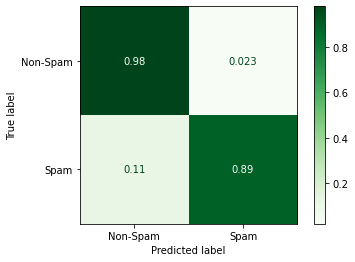

In [22]:
# plot the confusion matrix to visualize the performance
plot_confusion_matrix(cv_nb.best_estimator_, X_test, y_test, normalize='true', cmap='Greens')

## Try TfidfVectorizer()

In [23]:
# make the pipeline with TfidfVectorizer()
tf_pipe = make_pipeline(TfidfVectorizer(), MultinomialNB())
tf_pipe

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [24]:
# set the hyperparameters
param_grid = {
    'tfidfvectorizer__analyzer': ['word'],
    'tfidfvectorizer__stop_words': ['english', None],
    'tfidfvectorizer__lowercase' : [True, False],
    'tfidfvectorizer__norm' : ['l1', 'l2'],
    'tfidfvectorizer__ngram_range' : [(1,1), (1,2)],
    'tfidfvectorizer__use_idf' :  [True, False],
    'tfidfvectorizer__max_features' : [500, 1000, 1500, 2000, 2500, None],
    'multinomialnb__alpha' : np.linspace(0.1, 1, 10)
}

In [25]:
# set the gridsearch
tf_nb = GridSearchCV(tf_pipe, param_grid, cv=5, n_jobs=-1, verbose=2)

In [26]:
# fit the training data to the model and find the best model
tf_nb.fit(X_train, y_train)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'multinomialnb__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'tfidfvectorizer__analyzer': ['word'],
                         'tfidfvectorizer__lowercase': [True, False],
                         'tfidfvectorizer__max_features': [500, 1000, 1500,
                                                           2000, 2500, None],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
                         'tfidfvectorizer__norm': ['l1', 'l2'],
                         'tfidfvectorizer__stop_words': ['english', None],
                         'tfidfvectorizer__use_idf': [True, False]},
             verbose=2)

In [27]:
# check out the hyperparameter for the best model with TfidfVectorizer()
tf_nb.best_estimator_

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, max_features=2000,
                                 stop_words='english')),
                ('multinomialnb', MultinomialNB(alpha=0.2))])

In [28]:
# cross validate to check if the model is underfitting/overfitting
pipe_tf_nb = make_pipeline(TfidfVectorizer(lowercase=False, max_features=2000, stop_words='english'),\
                           MultinomialNB(alpha=0.2))

scores = cross_validate(pipe_tf_nb, X_train, y_train, return_train_score=True)
pd.DataFrame(scores).mean()

fit_time       0.046141
score_time     0.009402
test_score     0.976471
train_score    0.998039
dtype: float64

In [29]:
# the model looks good, apply it to the test data and check out the scores
print(classification_report(y_test, tf_nb.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

    Non-Spam       0.98      0.98      0.98       174
        Spam       0.83      0.83      0.83        18

    accuracy                           0.97       192
   macro avg       0.91      0.91      0.91       192
weighted avg       0.97      0.97      0.97       192



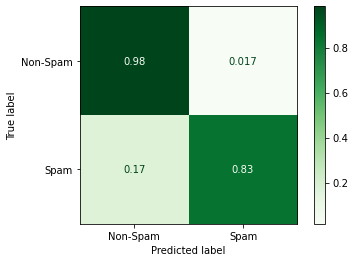

In [30]:
# plot the confusion matrix to visualize the performance
plot_confusion_matrix(tf_nb.best_estimator_, X_test, y_test, normalize='true', cmap='Greens')

In [31]:
print(classification_report(valid['Label'], cv_nb.best_estimator_.predict(valid['token'])))

              precision    recall  f1-score   support

    Non-Spam       0.84      0.96      0.90        49
        Spam       0.97      0.88      0.92        76

    accuracy                           0.91       125
   macro avg       0.91      0.92      0.91       125
weighted avg       0.92      0.91      0.91       125



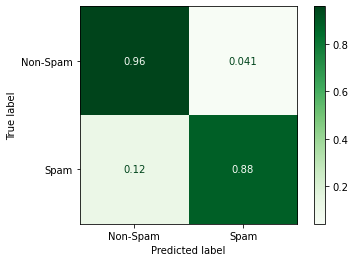

In [32]:
plot_confusion_matrix(cv_nb.best_estimator_, valid['token'], valid['Label'], normalize='true', cmap='Greens')